In [1]:
from IPython import display

# Data sources

The objective of this project is to investigate large-scale drivers of vegetation change in the Upper Midwest, U.S. over the last ~2,000 years of the pre-industrial Holocene. The data sources consist of reconstructions of the vegetation and dominant climate drivers over this time period.

## Vegetation data

The landscape-scale vegetation was statistically reconstructed from fossil pollen time series using the STEPPS model so that the response variable in the present analysis is fractional composition. Fractional composition is the relative composition of different taxa in a given area of interest, with the constraint that the composition of each taxon in a given area sums to 1. That is, the composition of a given location with species $j$ from $1, ..., J$ can be represented as a vector $\vec{y} = \{y_1,...,y_J\}$. The STEPPS data product borrows strength over time ($t$) and over space ($s$), providing statistically smoothed estimates of fractional composition at regular intervals in time (every 100 years, $\delta t = 100$) and in space (every 8 km, $\delta s = 8$).

In total, the STEPPS data product consists of the fraction of 12 tree taxa over a spatially smoothed landscape with a resolution of 8 km over a temporally smoothed time span of 2,000 years in 100 year intervals. This can be denoted as $\vec{y}_{t,s}$ where $t$ denotes the time step and $s$ denotes the grid cell.

Using these data, one can investigate the spatial and temporal variability of forest composition and taxon ranges. In Figure 1, for example, the spatial variability of pine proportion is pronounced, while in Figure 2, I highlight the temporal variability of pine, particularly from 300 to 200 years before present (y BP).

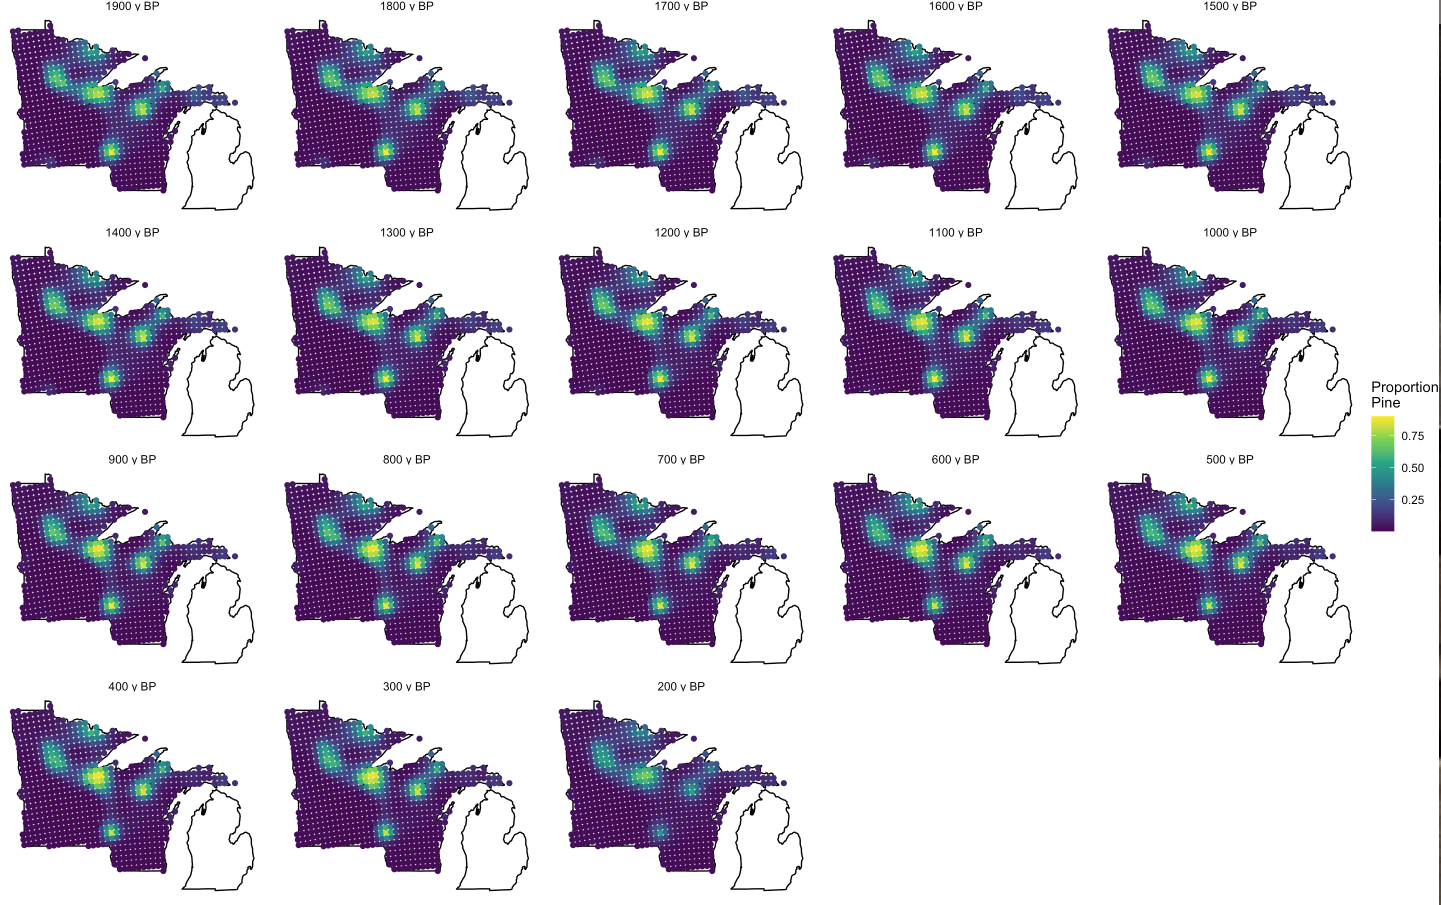

In [2]:
display.Image('/Users/Aly/Desktop/image1.png')

**Figure 1.** The proportion of each grid cell occupied by pine across the Upper Midwest and over time. The colors indicate the proportion of pine in the grid cell. Each facet represents a different 100 year interval. Note that the facets are in years before present (y BP), so that the top left facet is the most ancient and the bottom right panel is the most recent.

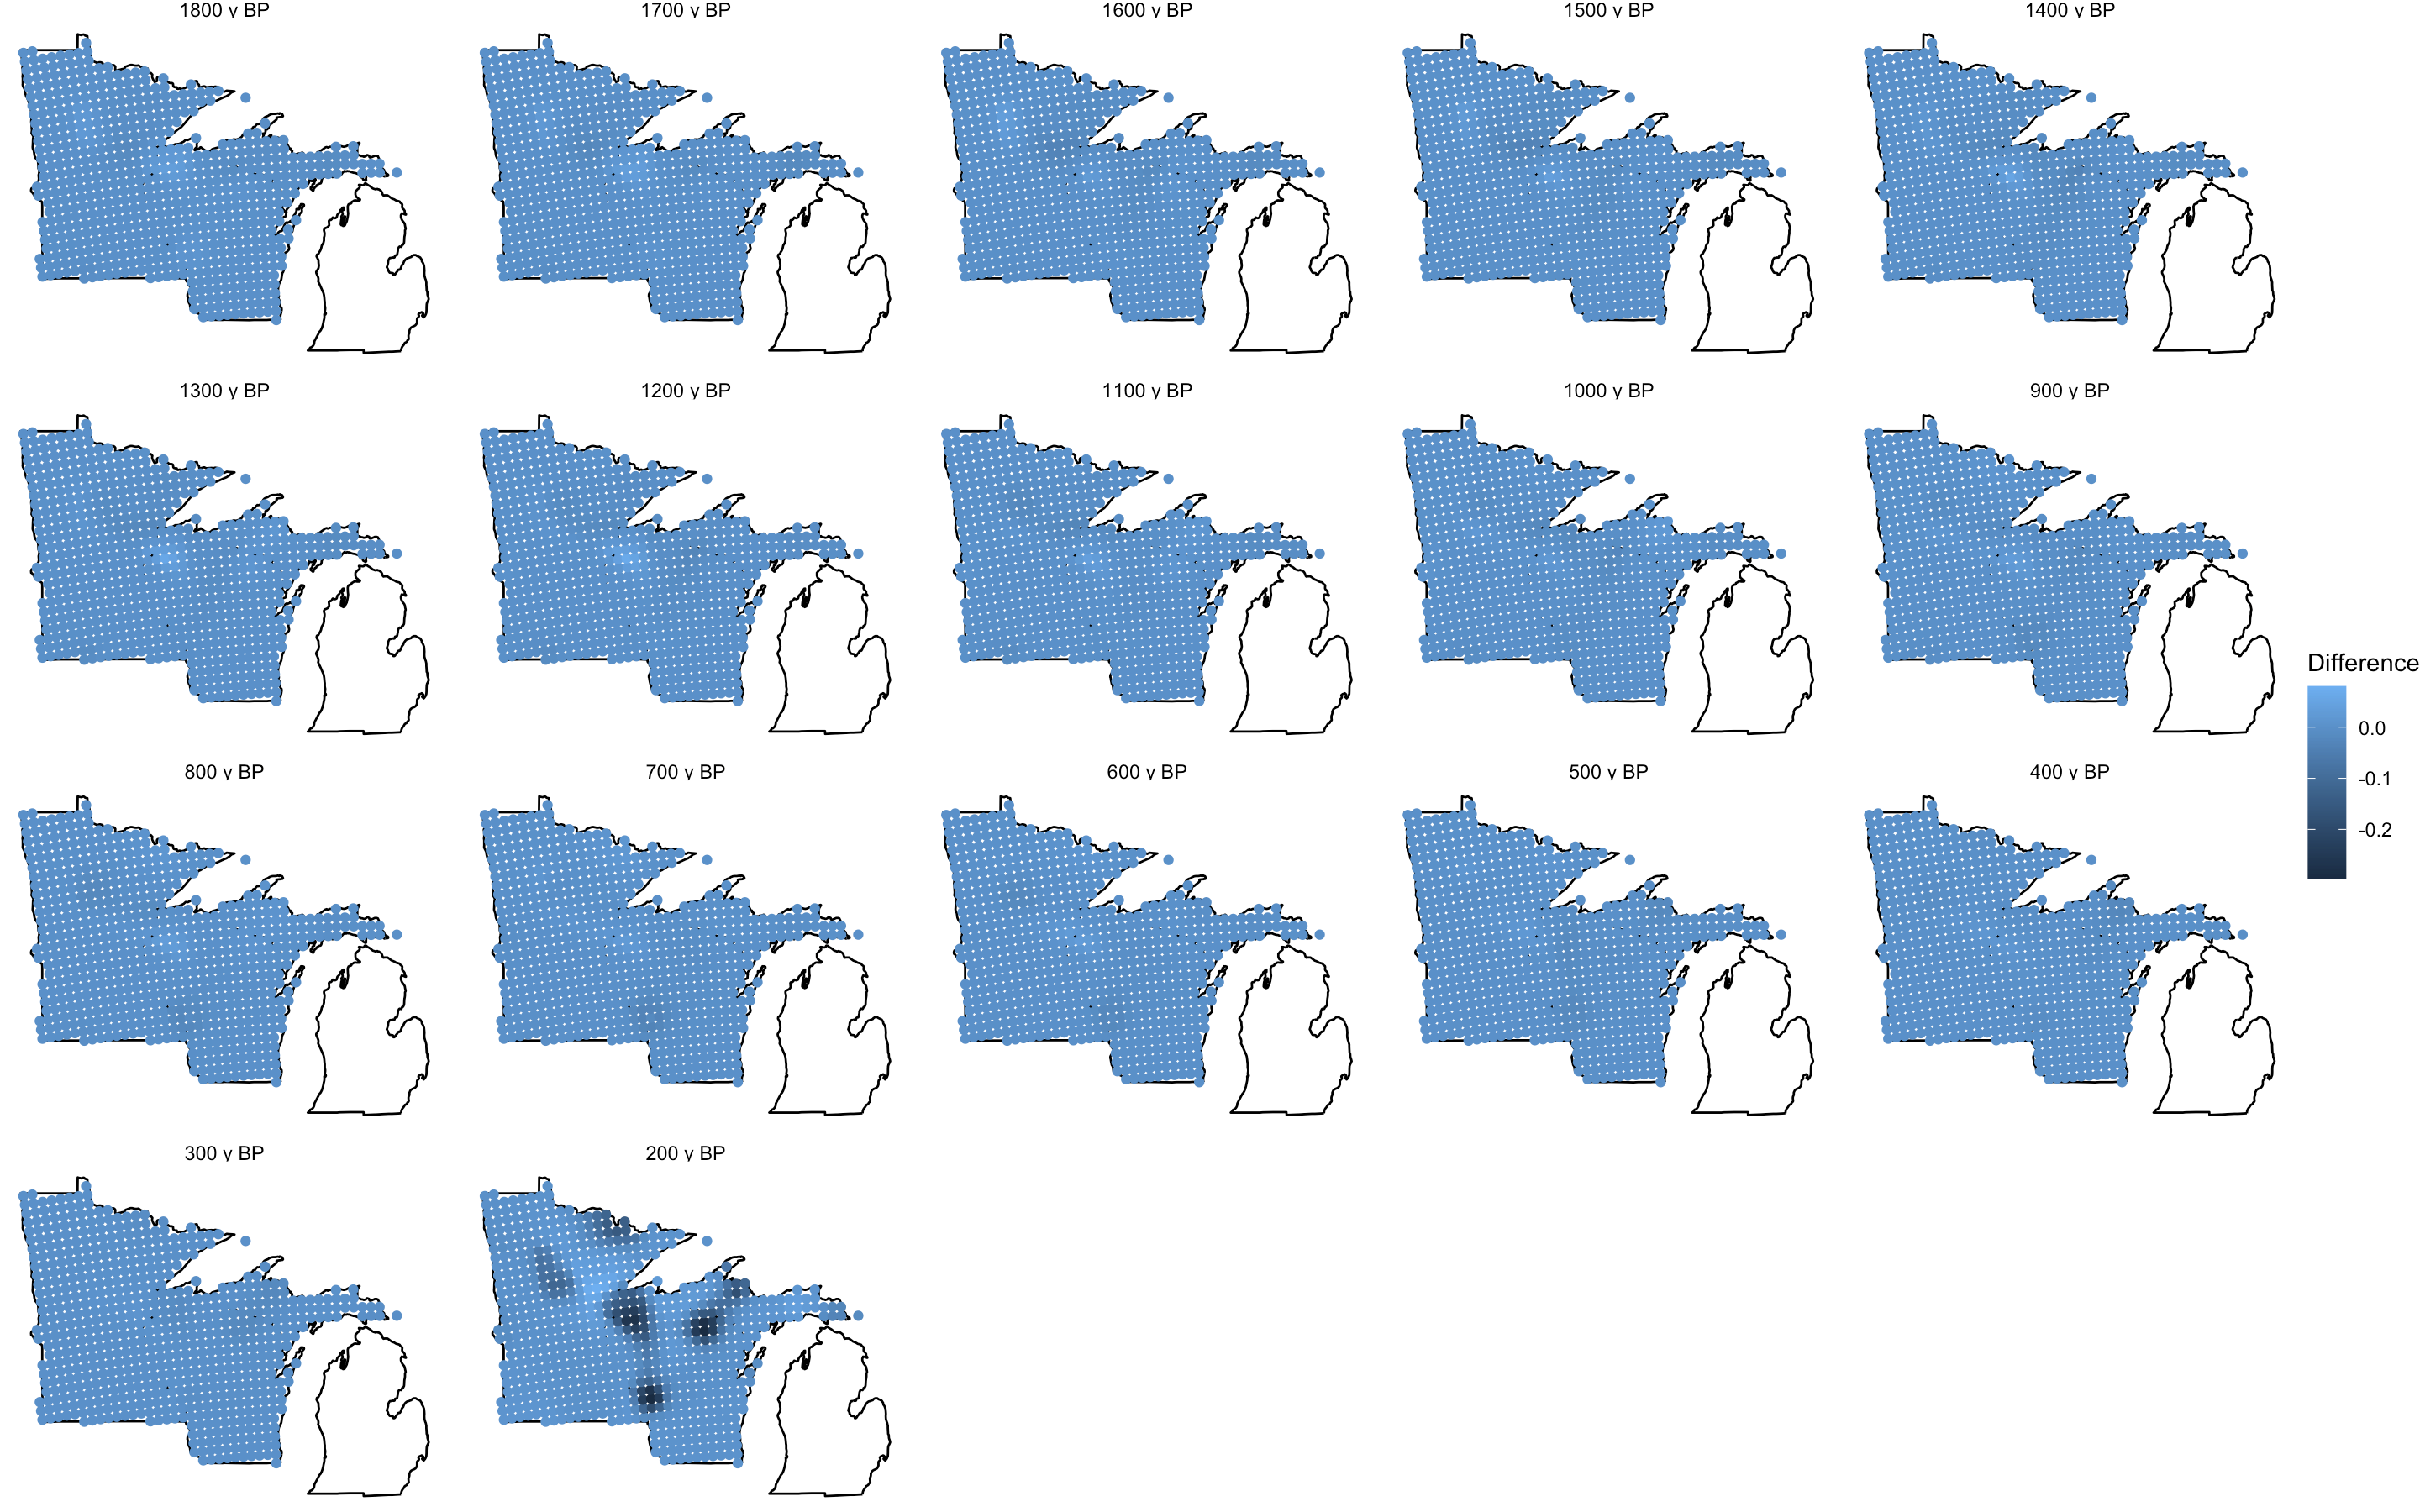

In [3]:
display.Image('/Users/Aly/Desktop/image2.png')

**Figure 2.** Change in the proportion of each grid cell occupied by pine across space and time. Each panel represents the difference between the time period listed and the previous time period. For example, the top left panel is the difference in pine proportion between 1900 years before present (y BP) and 1800 y BP.

## Climate data

Average annual temperature and total annual precipitation were used in combination with fractional composition reconstructions to understand the drivers of vegetation change. I chose to focus on temperature and precipitation because these two variables have higher certainty in modeling at the paleo time scale than other climate variables. I downloaded CMIP6 reconstructions from the Earth Science Grid Federation (ESGF) data store using provided wget download scripts. I used the following specifications:

- past2k experiment
- r1i1p1f1 variant
- gn grid label
- pr (precipitation) or tas (surface air temperature) variable
- 250 km nominal resolution
- MPI-ESM Earth System Model

I downloaded all available data using these specifications. Then, I subsetted the data to only those points falling within our spatial region of interest, ecnompassing the Upper Midwest, US. Specifically, I kept all points within $\pm 1$ degree of the boundary of the fractional composition reconstructions (Figures 3 & 4). 

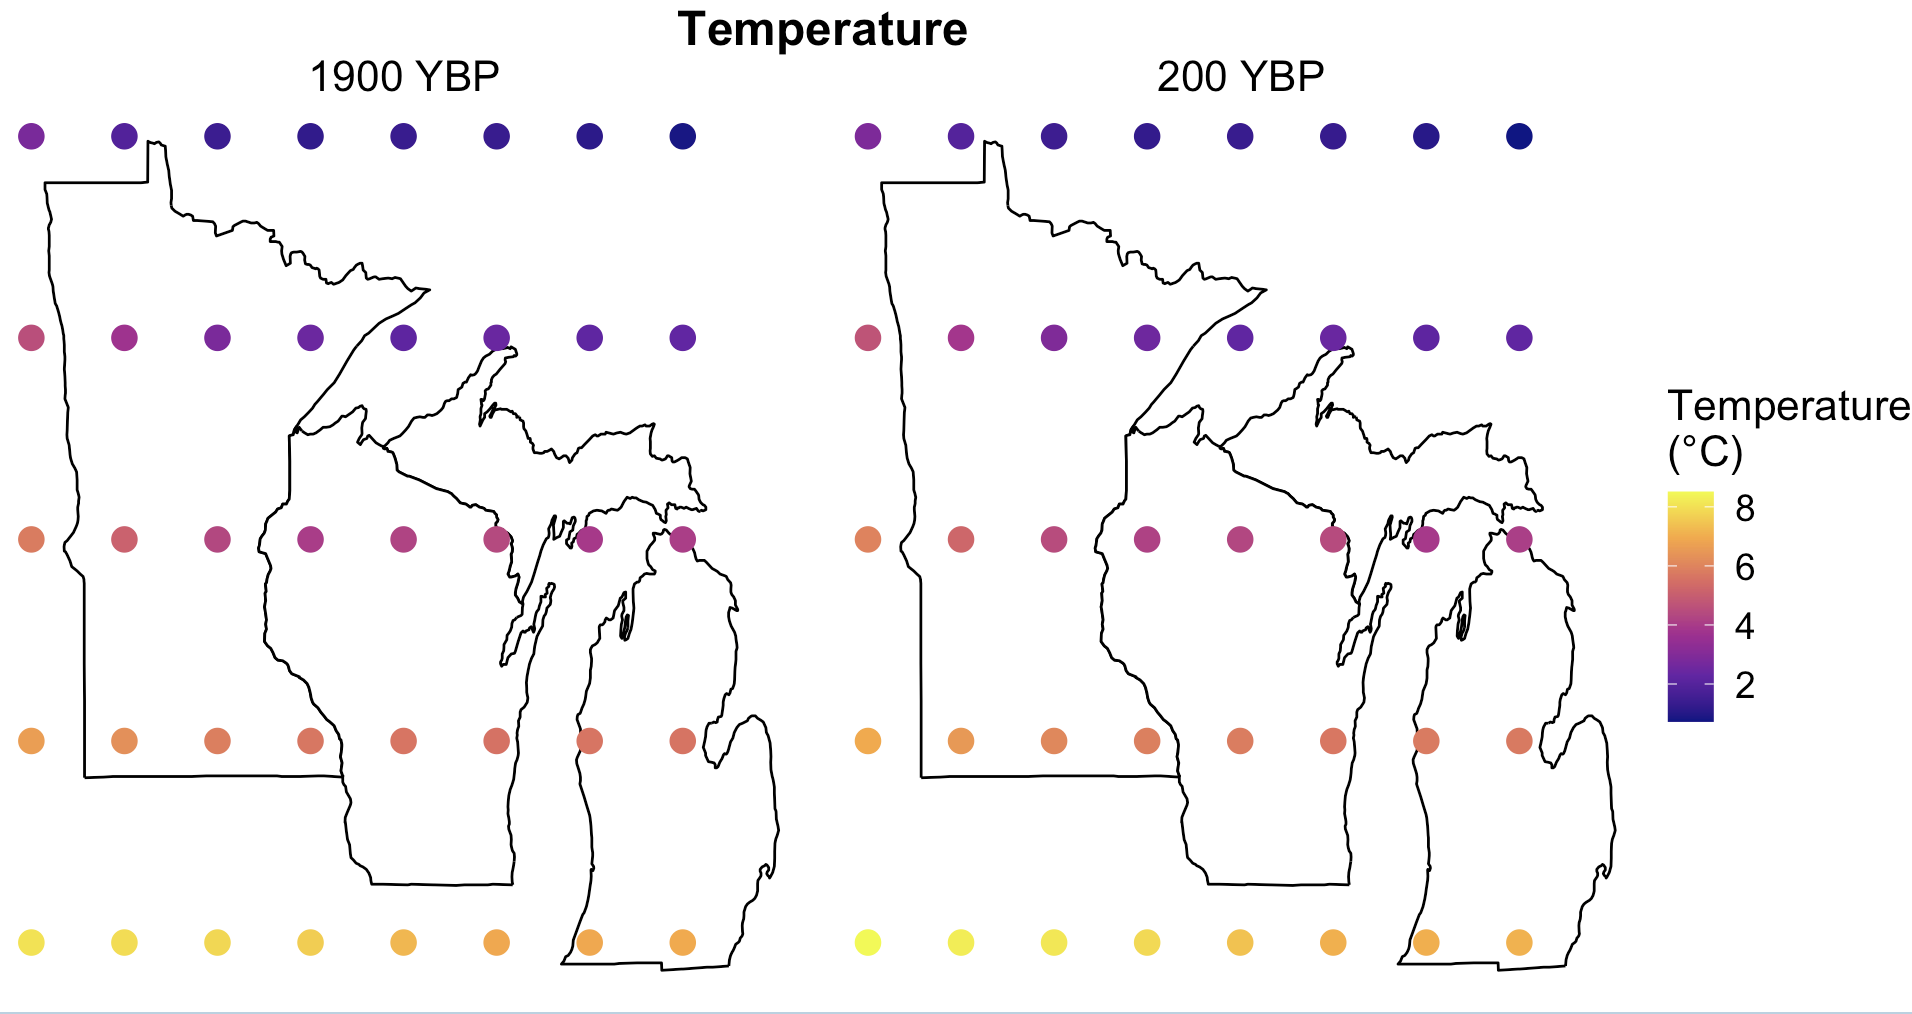

In [4]:
display.Image('/Users/Aly/Desktop/image3.png')

**Figure 3.** Locations of temperature reconstructions using the 250 km resolution past2k reconstructions from CMIP6. Left: 1900 years before present (YBP). Right: 200 YBP. Colors correspond to average annual surface air temperature at the given location, averaged over 50 years surrounding the target date.

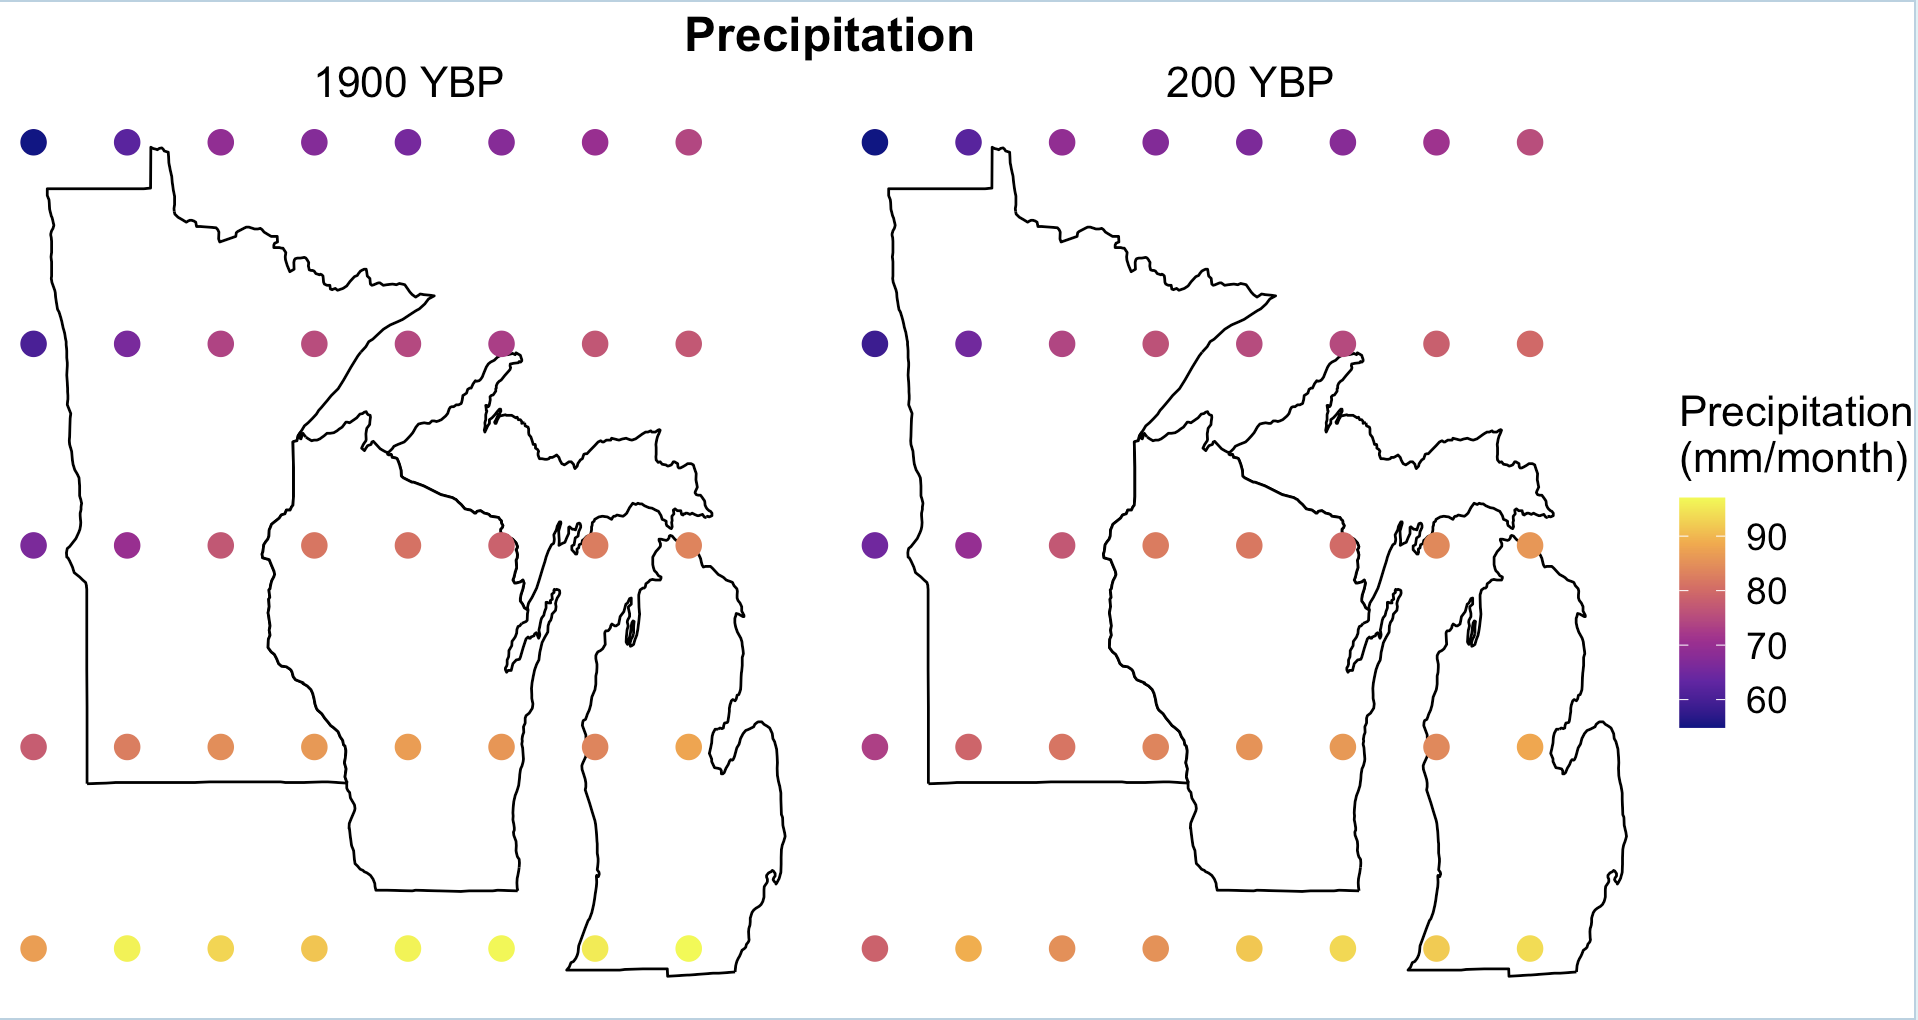

In [6]:
display.Image('/Users/Aly/Desktop/image4.png')

**Figure 4.** Locations of precipitation reconstructions. Interpretation as in Figure 3.

I computed moving averages around each year for which fractional composition data are available using 50 years of data ($\pm 25$ years). For both temperature and precipitation, I computed simple averages for each location across all months and years within the moving window. To spatially match the fractional composition and climate reconstructions, I used the `rgeos` R package to calculate the pair-wise distance between the center of each fractional composition grid cell (Figure 1) and each climate data point (Figure 3). Then, for each fractional composition grid cell, I found the nearest climate data point and assigned the fractional composition grid cell the corresponding temperature and precipitation values.

To use the data, I exercised a few post-processing steps. First, I converted longitude to the -180 to 180 scale. Next, I converted time from days since 01-01-1850 (Gregorian calendar) to year. Then I converted temperature from Kelvin to Celsius ($T_C = T_K - 273.15$ where $T_C$ is temperature in Celsius and $T_K$ is temperature in Kelvin). Finally, I converted precipitation flux ($kg \; m^{-2} \; s^{-1}$) to precipitation ($mm \; \text{month}^{-1}$) using the following:

$$P_m = P_f \times 24 \times 60 \times 60 \times 30$$

where $P_m$ is precipitation per month and $P_f$ is precipitation flux. This essentially just says there are 60 seconds in a minute, 60 minutes, in an hour, 24 hours in a day, and 30 days in a month. In so doing, we assume that 1 kg of water is spread over 1 m<sup>2</sup>, making it 1 mm thick.

# Statistical model

## Generalized Joint Attribute Model

### Model description

I began by using the Generalized Joint Attribute Model (GJAM) devloped by Jim Clark *et al.* for investigating drivers of community assembly across diverse ecological systems. Briefly, the core of the model is a multiple linear regression model, whherein coefficients are estimated for the relationship between any number of independent regressors and any number of response variables. In this case, I used temperature and precipitation as the covariates:

$$y_{s,j} = \beta_0 + \beta_{1,j}x_{s,1} + \beta_{2,j}x_{s,1},$$

where fractional composition $y$ of each location $s$ and taxon $j$ is a function of the temperature $x_{s,1}$ and precipitation $x_{s,2}$. Note that each taxon can respond independently to the climate drivers via seperate coefficients $\beta_{1,j}$ and $\beta_{2,j}$.

A second component of the model allows for the joint estimation of all the response variables, so that a latent covariance matrix is estimated. This component of the model is important for the present work because it allows me to infer the relationship between taxa that is *not* accounted for by overlap in environmental preference.

More information about the model can be found in Clark *et al.* (2017): http://onlinelibrary.wiley.com/doi/abs/10.1002/ecs2.4328.

### Model implementation

I used the `gjam` R package (Clark et al. 2017) to implement the model. I specified the formula `~ Temperature + Precipitation` indciating that vegetation should be modeled as a function of the temperature and precipitation drivers described above. The model automatically assumes a full covariance matrix between all response variables. The model uses an MCMC algorithm, for which I specified 1,000 iterations with 8,000 burn-in. The `gjam` package only permits running a single MCMC chain at a time, so the model was independently run three times. This is equivalent to specifying three chains in a traditional MCMC compiler. I additionally specified that the data are type `FC`, for fractional composition, which is used internally in the GJAM model to conform to the sum-to-one constraint of the data.

### Preliminary results

An examination of in-sample prediction vs. observed fractional composition reveals that the model predicts taxa well at low fraction, but significantly underpredicts taxa at higher fractions (Figure 5). This is likely a result of the fact that our data are strongly skewed towards low fraction for any given taxon in a given grid cell (Figure 5). Inverse prediction, wherein the fractional composition is used to predict the climate drivers, suggests that the model is capturing the relationship between climate and vegetation fairly well (Figure 6).

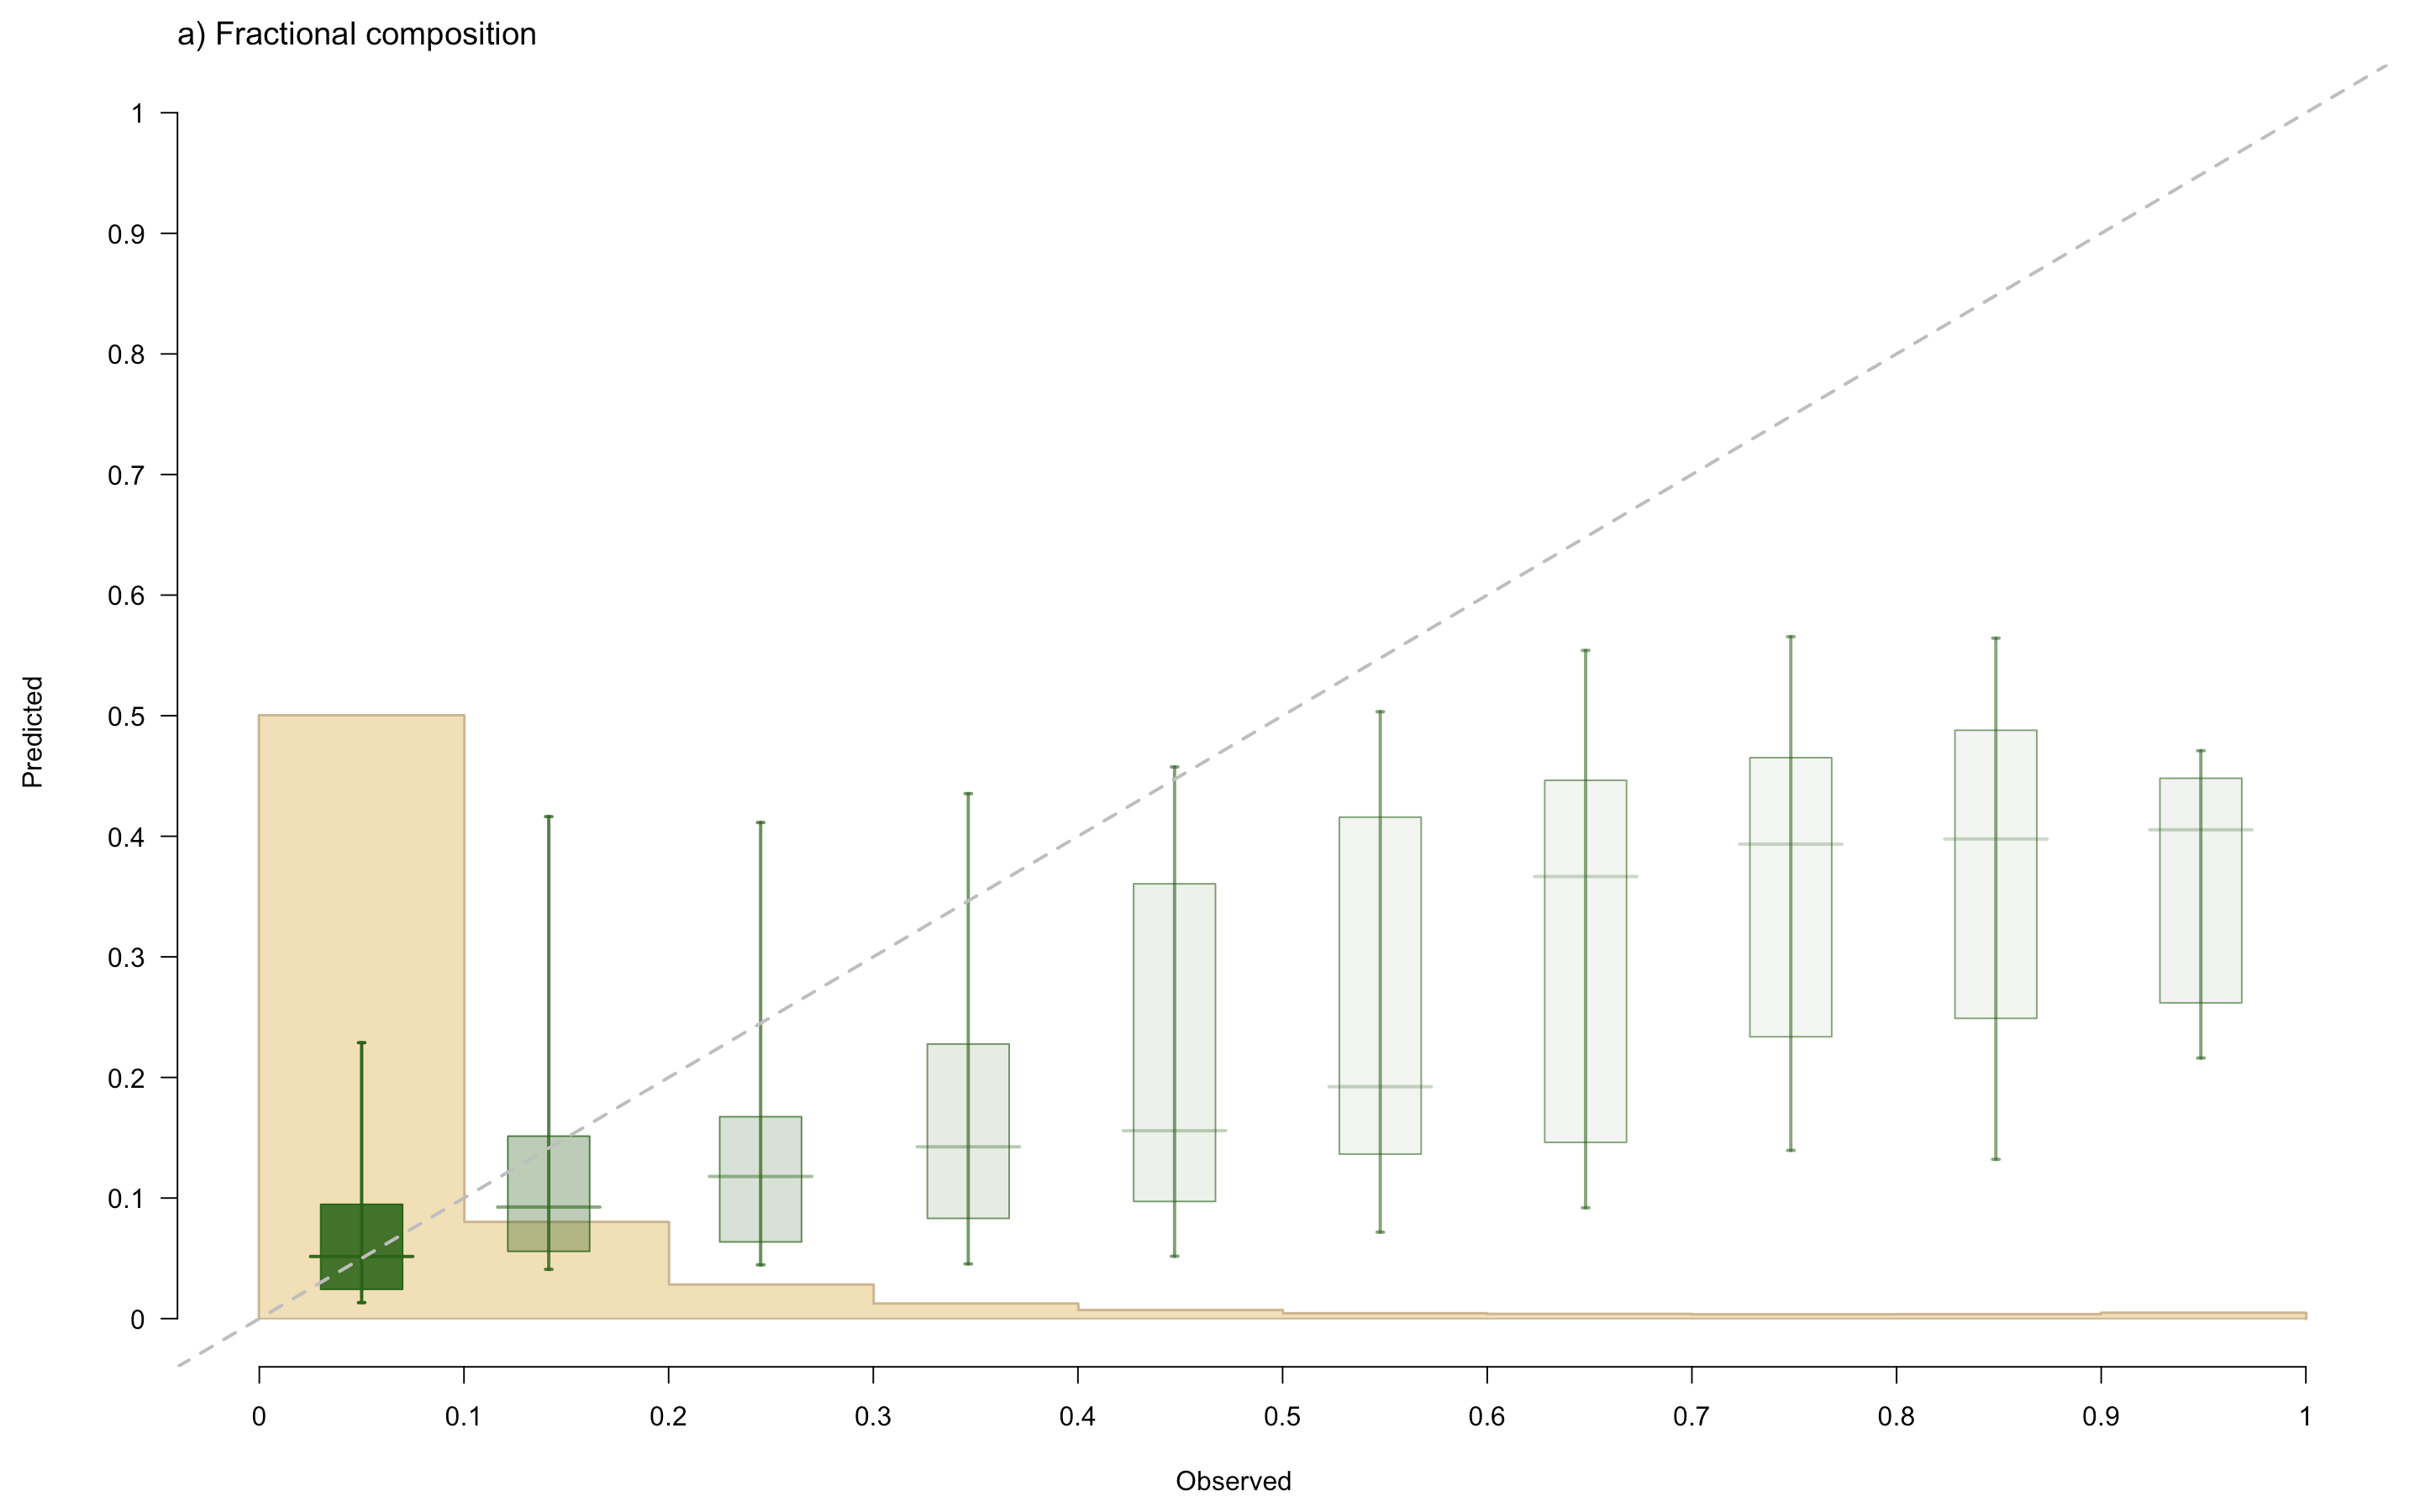

In [7]:
display.Image('/Users/Aly/Desktop/image5.png')

**Figure 5.** Observed vs. predicted fractional composition using the default in-sample prediction method in the `gjam` R package. The yellow histogram shows the frequency of observed fractions. The green boxes and whiskers show the predicted fraction, with uncertainty in both the observation and the prediction. The dashed line is the 1:1 line of observed:predicted. The shading of the box represents the divergence of the prediction from the 1:1 line.

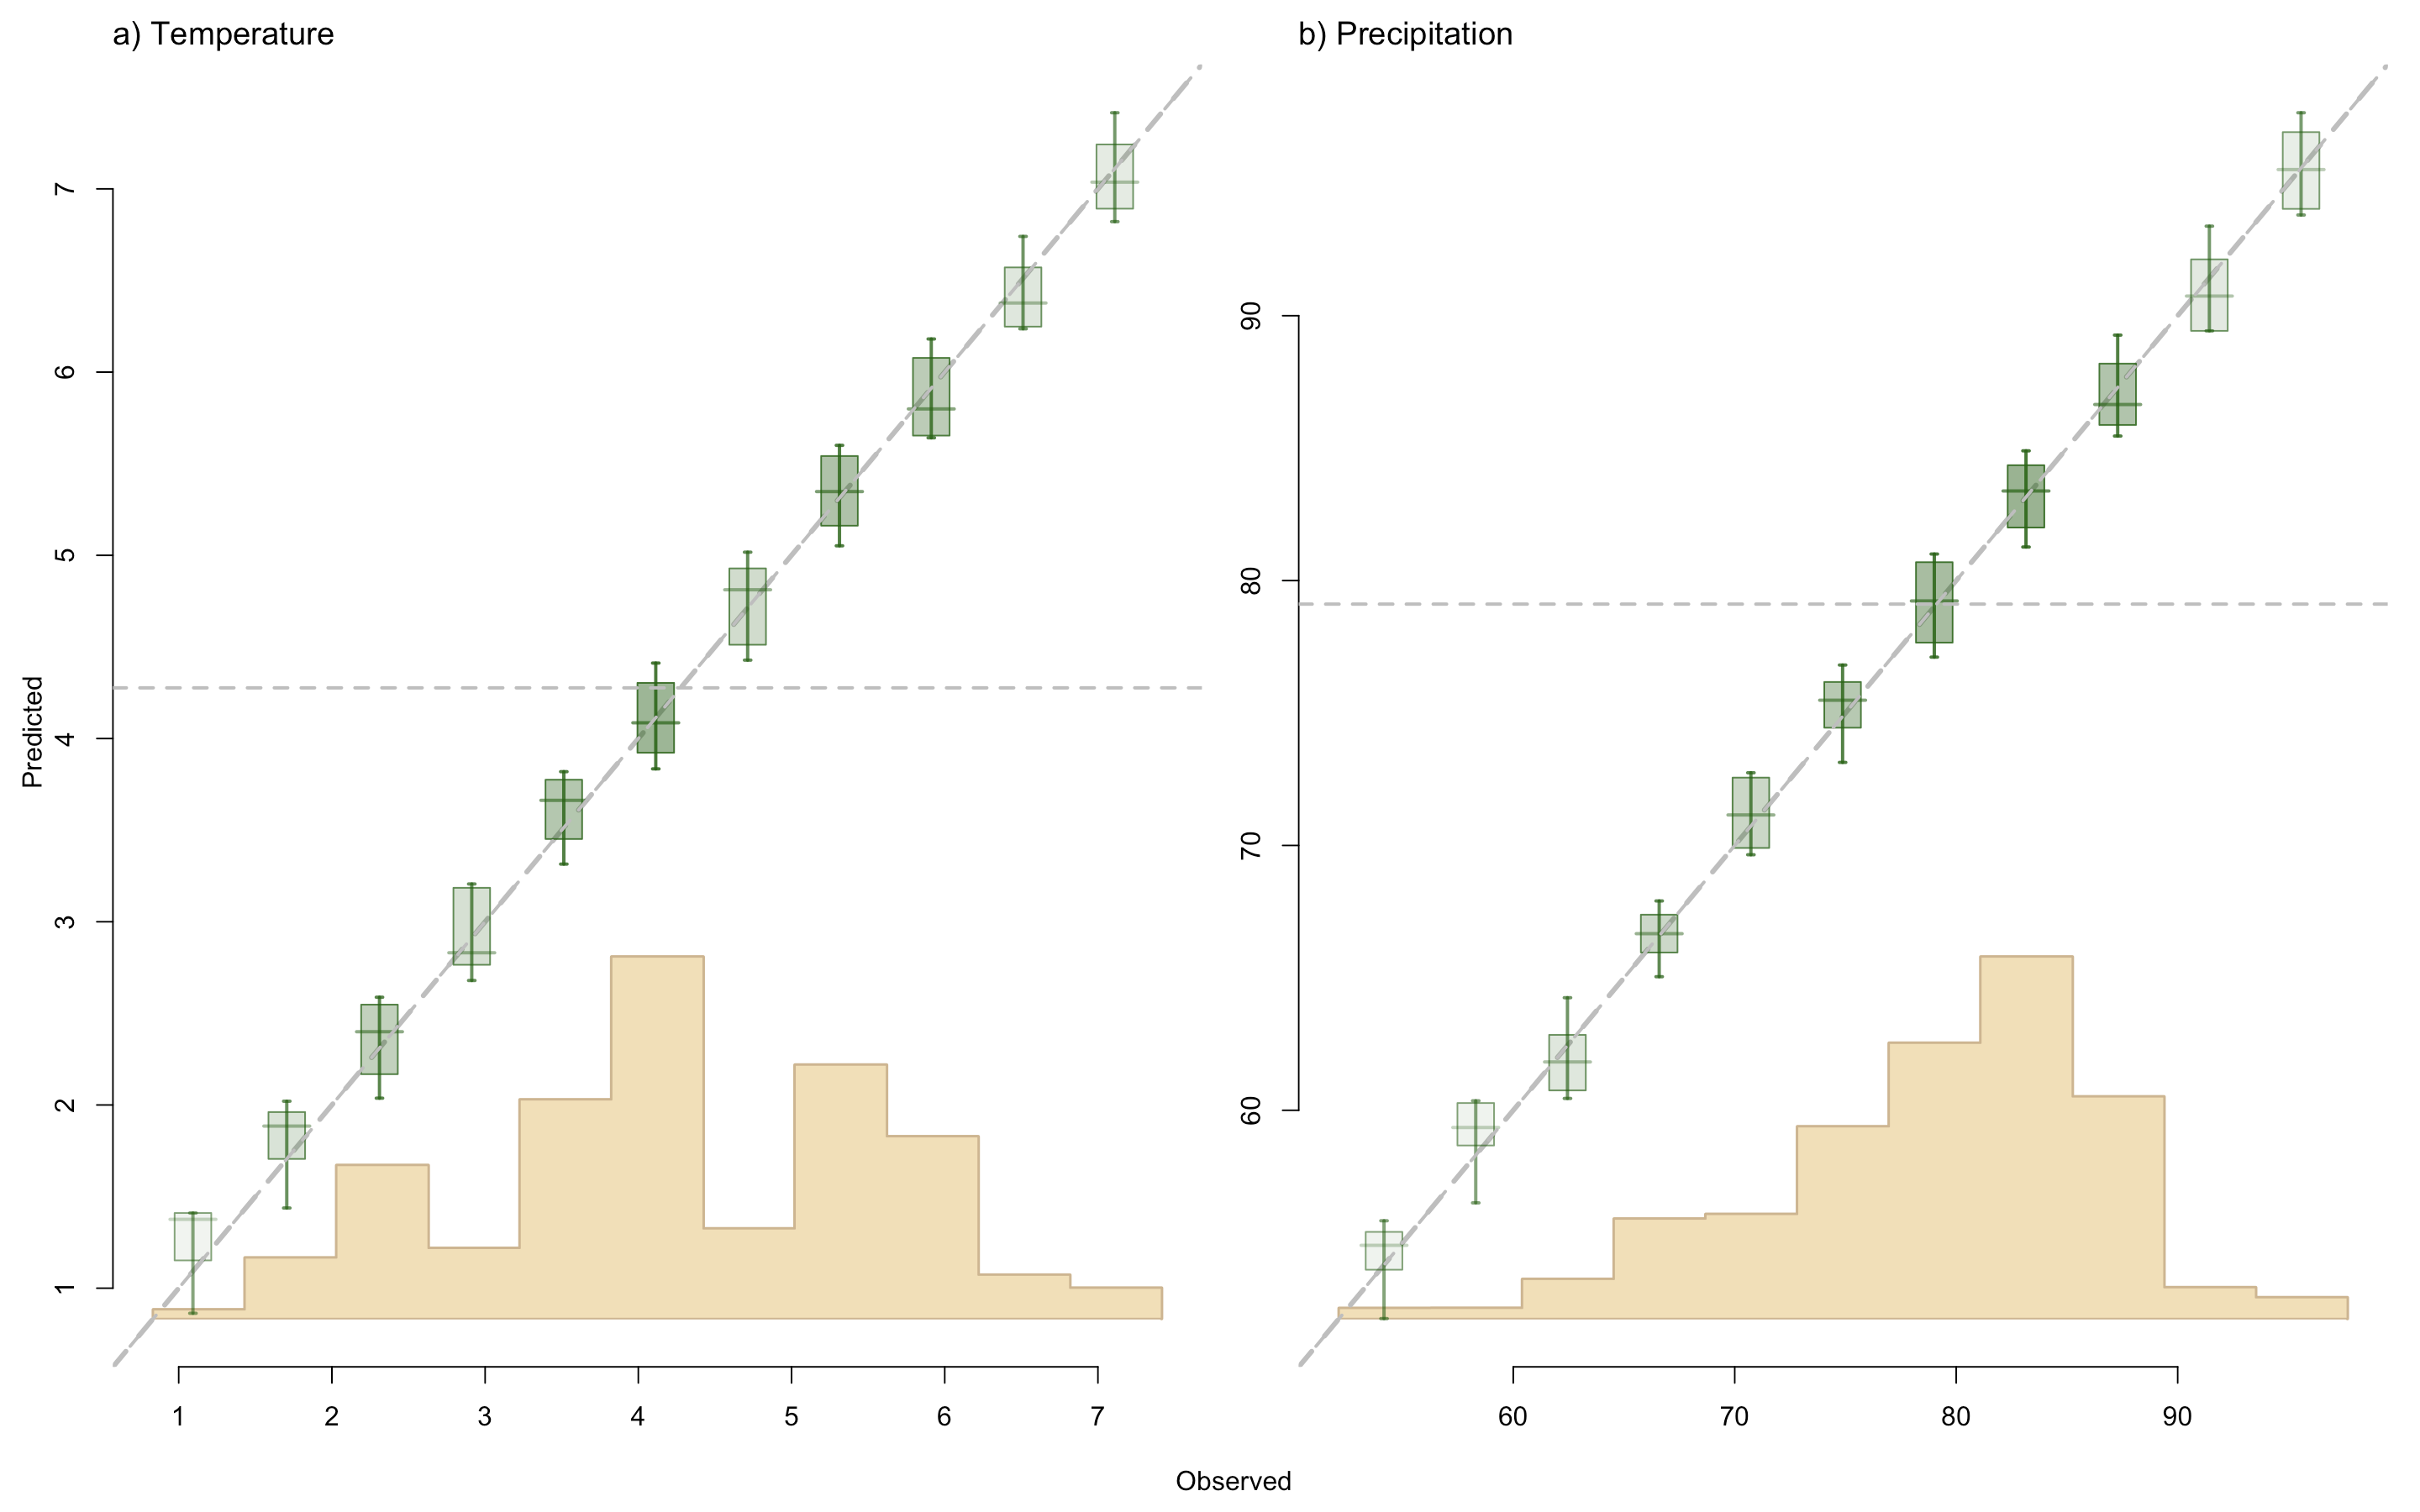

In [8]:
display.Image('/Users/Aly/Desktop/image6.png')

**Figure 6.** Observed vs. predicted plots for the inverse prediction of the two climate drivers (explained above). (a) Temperature. (b) Precipitation.

#### Sensitivity of vegetation to climate drivers

Overall, my results show that the vegetation is more sensitive to differences in temperature than differences in precipitation (Figure 7). On average, elm, oak, and ash are positively correlated with temperature, while spruce, birch, conifers, tamarack, pine, and hemlock are negatively correlated with temperature (Figure 8). This is expected given the spatial distribution of these taxa in the study region. Hemlock, beech, pine, birch, maple, conifers, and spurce are positively correlated with precipitation, while hardwoods, elm, ash, tamarack, and oak are negatively correlated with precipitation (Figure 9). Again, many of these results are expected, with the positively correlated species on average preferring more mesic habitats. It should be noted that these results correspond to correlations across both space and time. Neither space nor time is explicitly accounted for in this model.

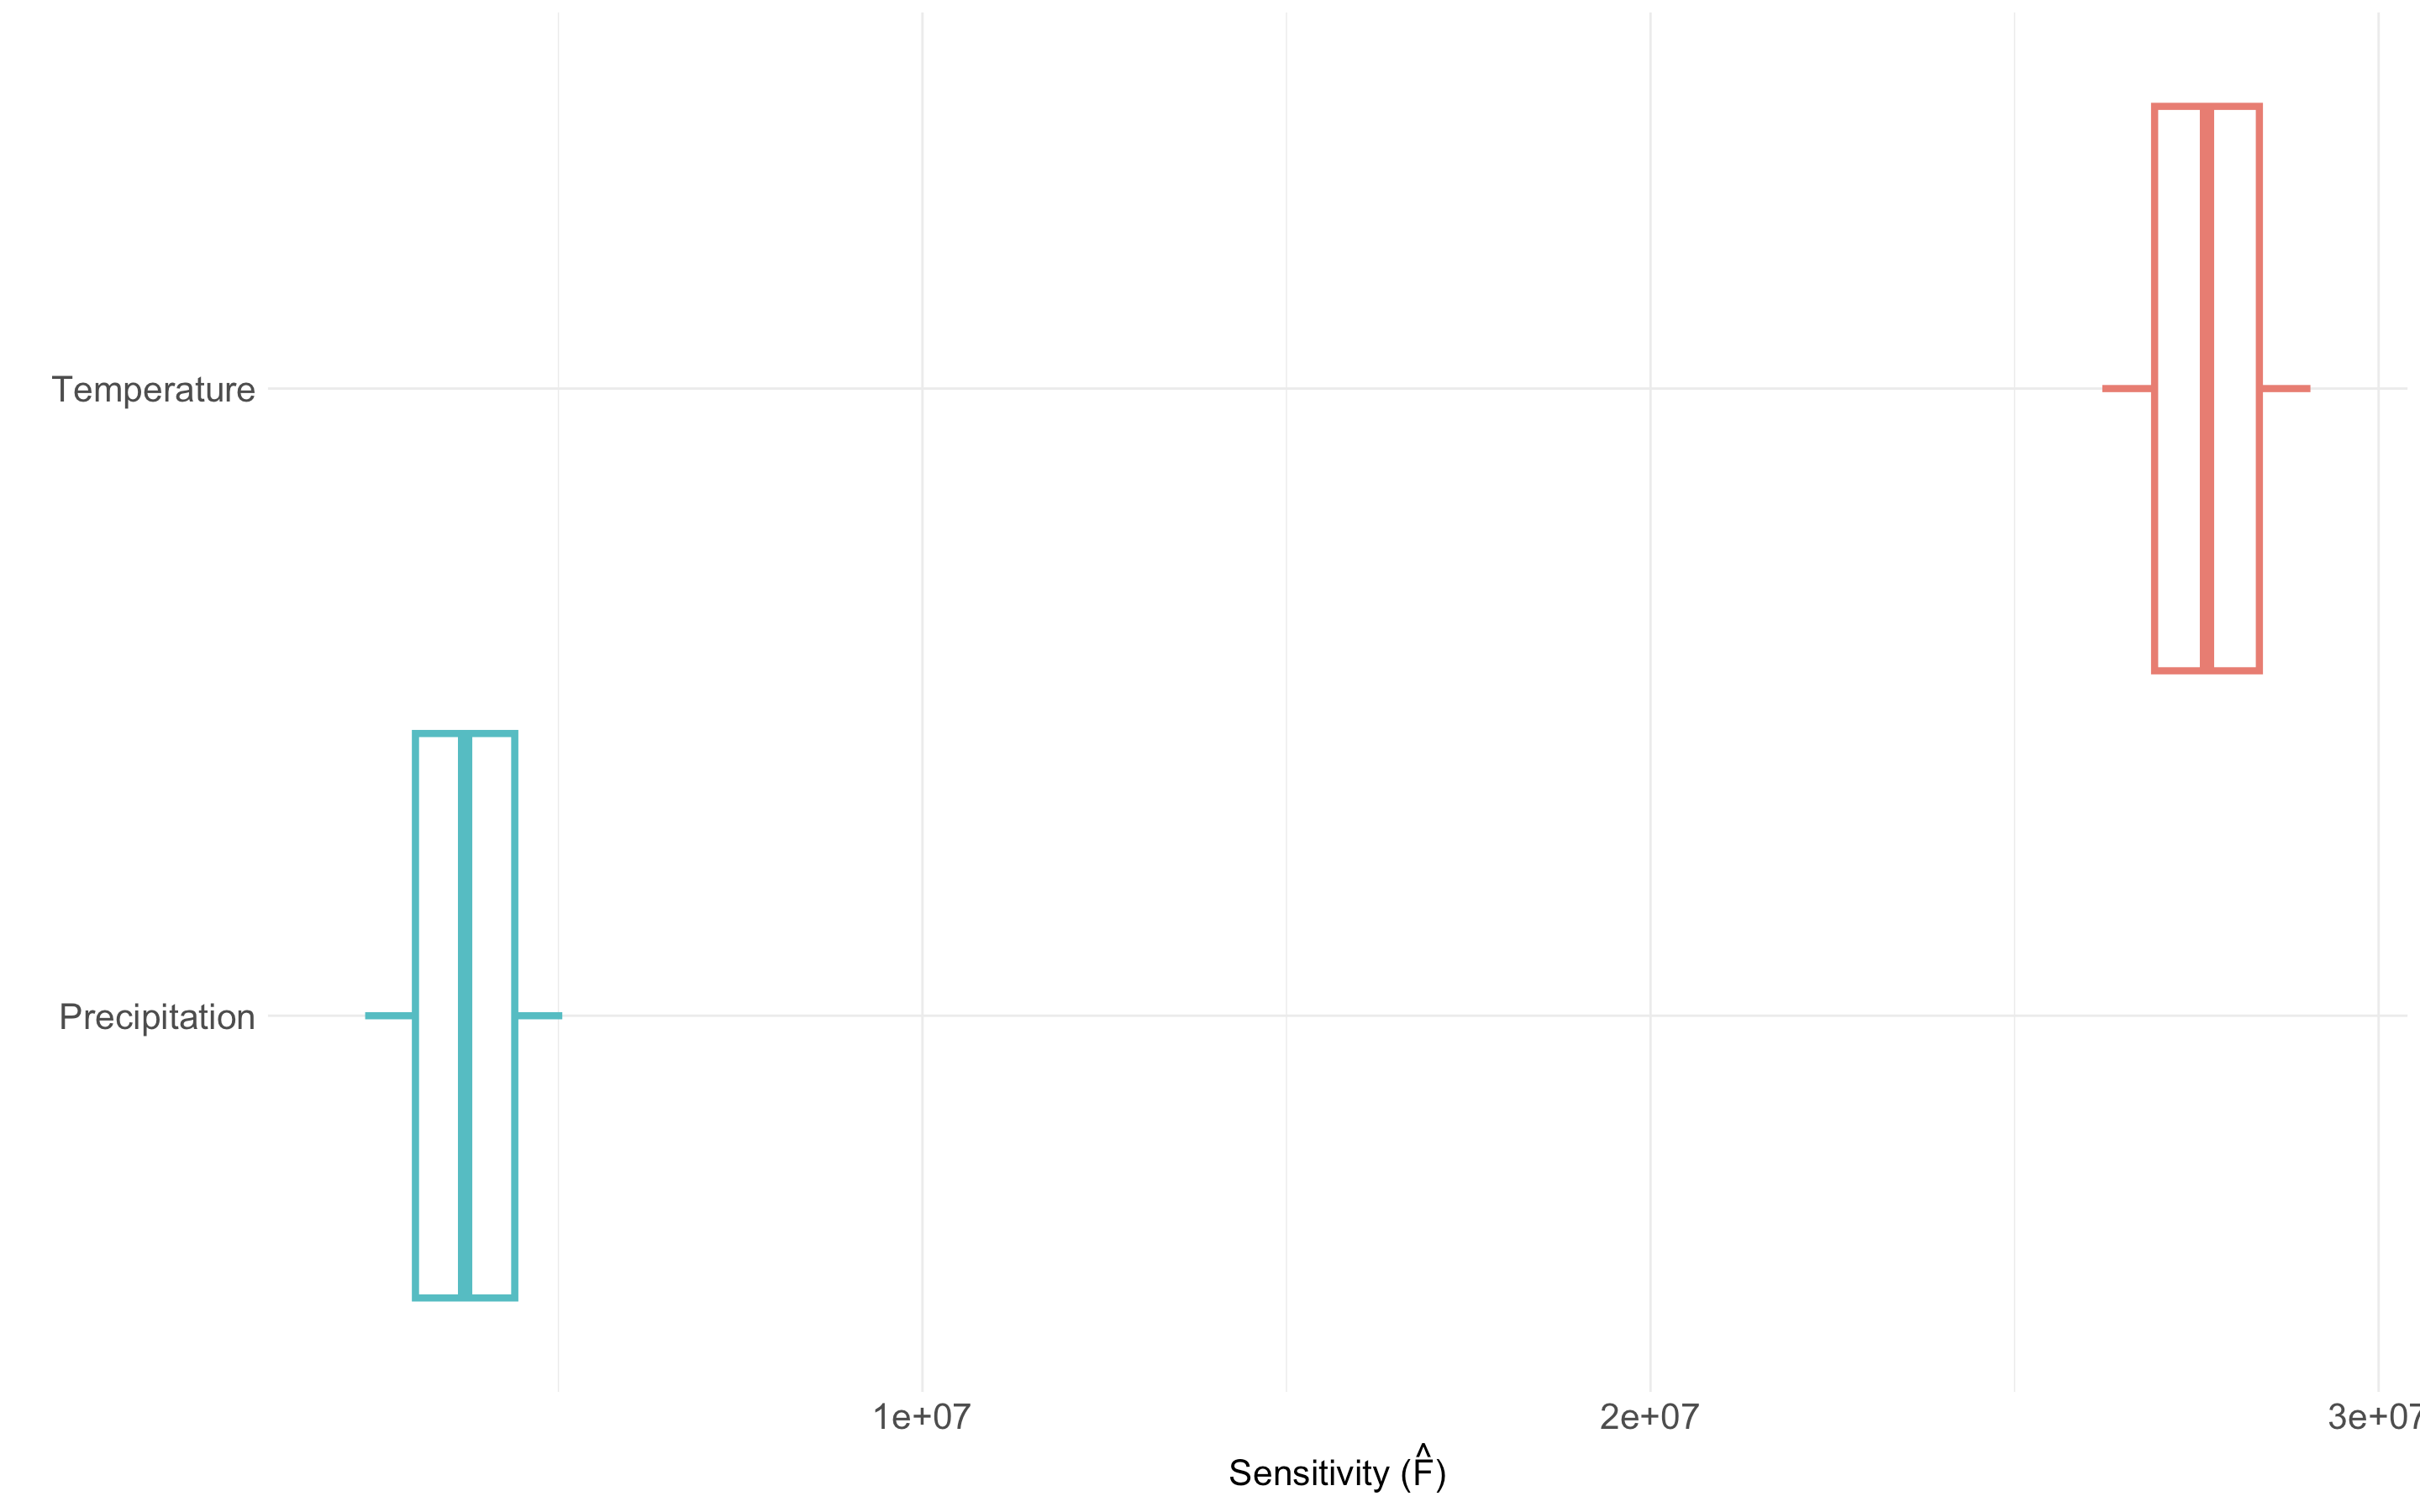

In [10]:
display.Image('/Users/Aly/Desktop/image7.png')

**Figure 7.** Overall sensitivity of fractional composition to differences in the climate drivers, temperature and precipitation. Sensitivity summarizes the effect size of the change in the repsonse variable (fractional composition) with a change in the given driver. A greater sensitivity indicates that fractional composition changes more for a given change in the climate driver. Therefore, one can infer that overall, fractional composition is more sensitive to temperature than to precipitation.

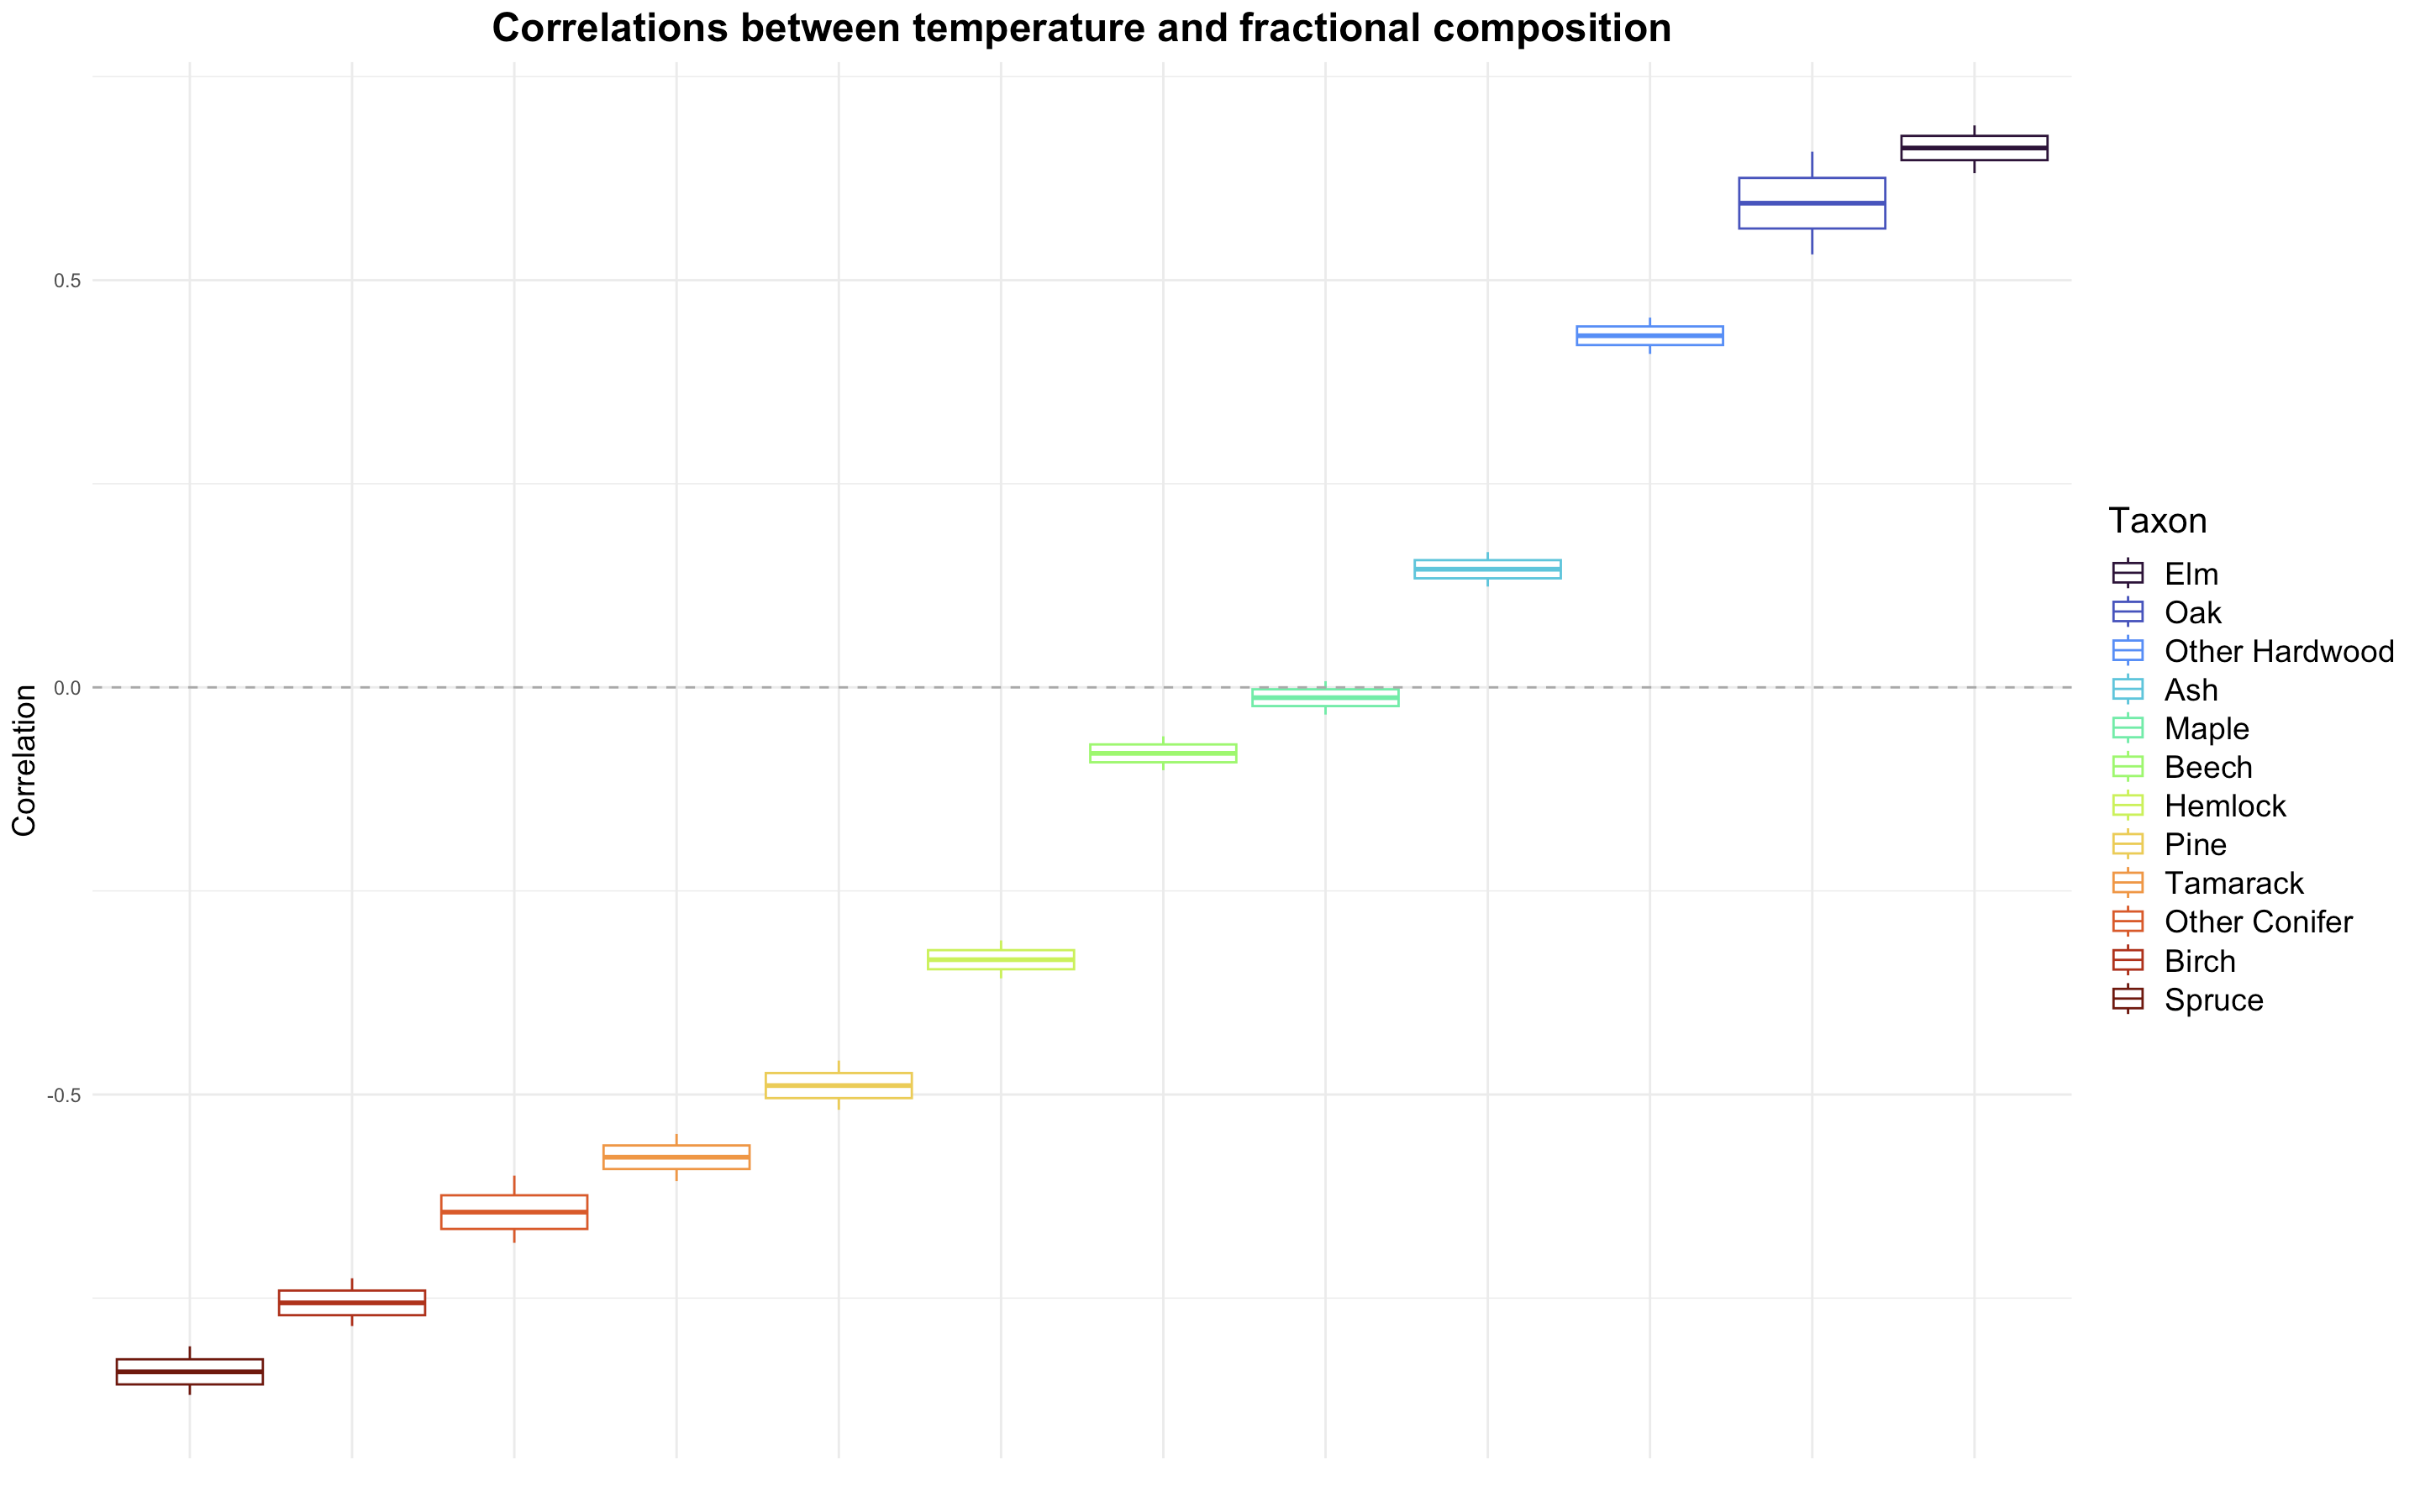

In [11]:
display.Image('/Users/Aly/Desktop/image8.png')

**Figure 8.** Correlation coefficients relating the cliamte driver temperature to the fraction of a given grid cell occupied by each taxon. The y-axis is the correlation estimate. Boxes and whiskers show the median $\pm$ 95% credible intervals from the posterior distributions of each coefficient. Colors in the legend correspond to the colors of the boxes, with the colors in the same order in the legend and in the plot. The dashed horizontal line shows 0. Boxes and whiskers above zero show a positive trend with temperature: an increase in temperature corresponds to an increase in the fraction of the grid cell occupied by the given taxon on average. Boxes and whiskers below zero show a negative trend with temperature on average.

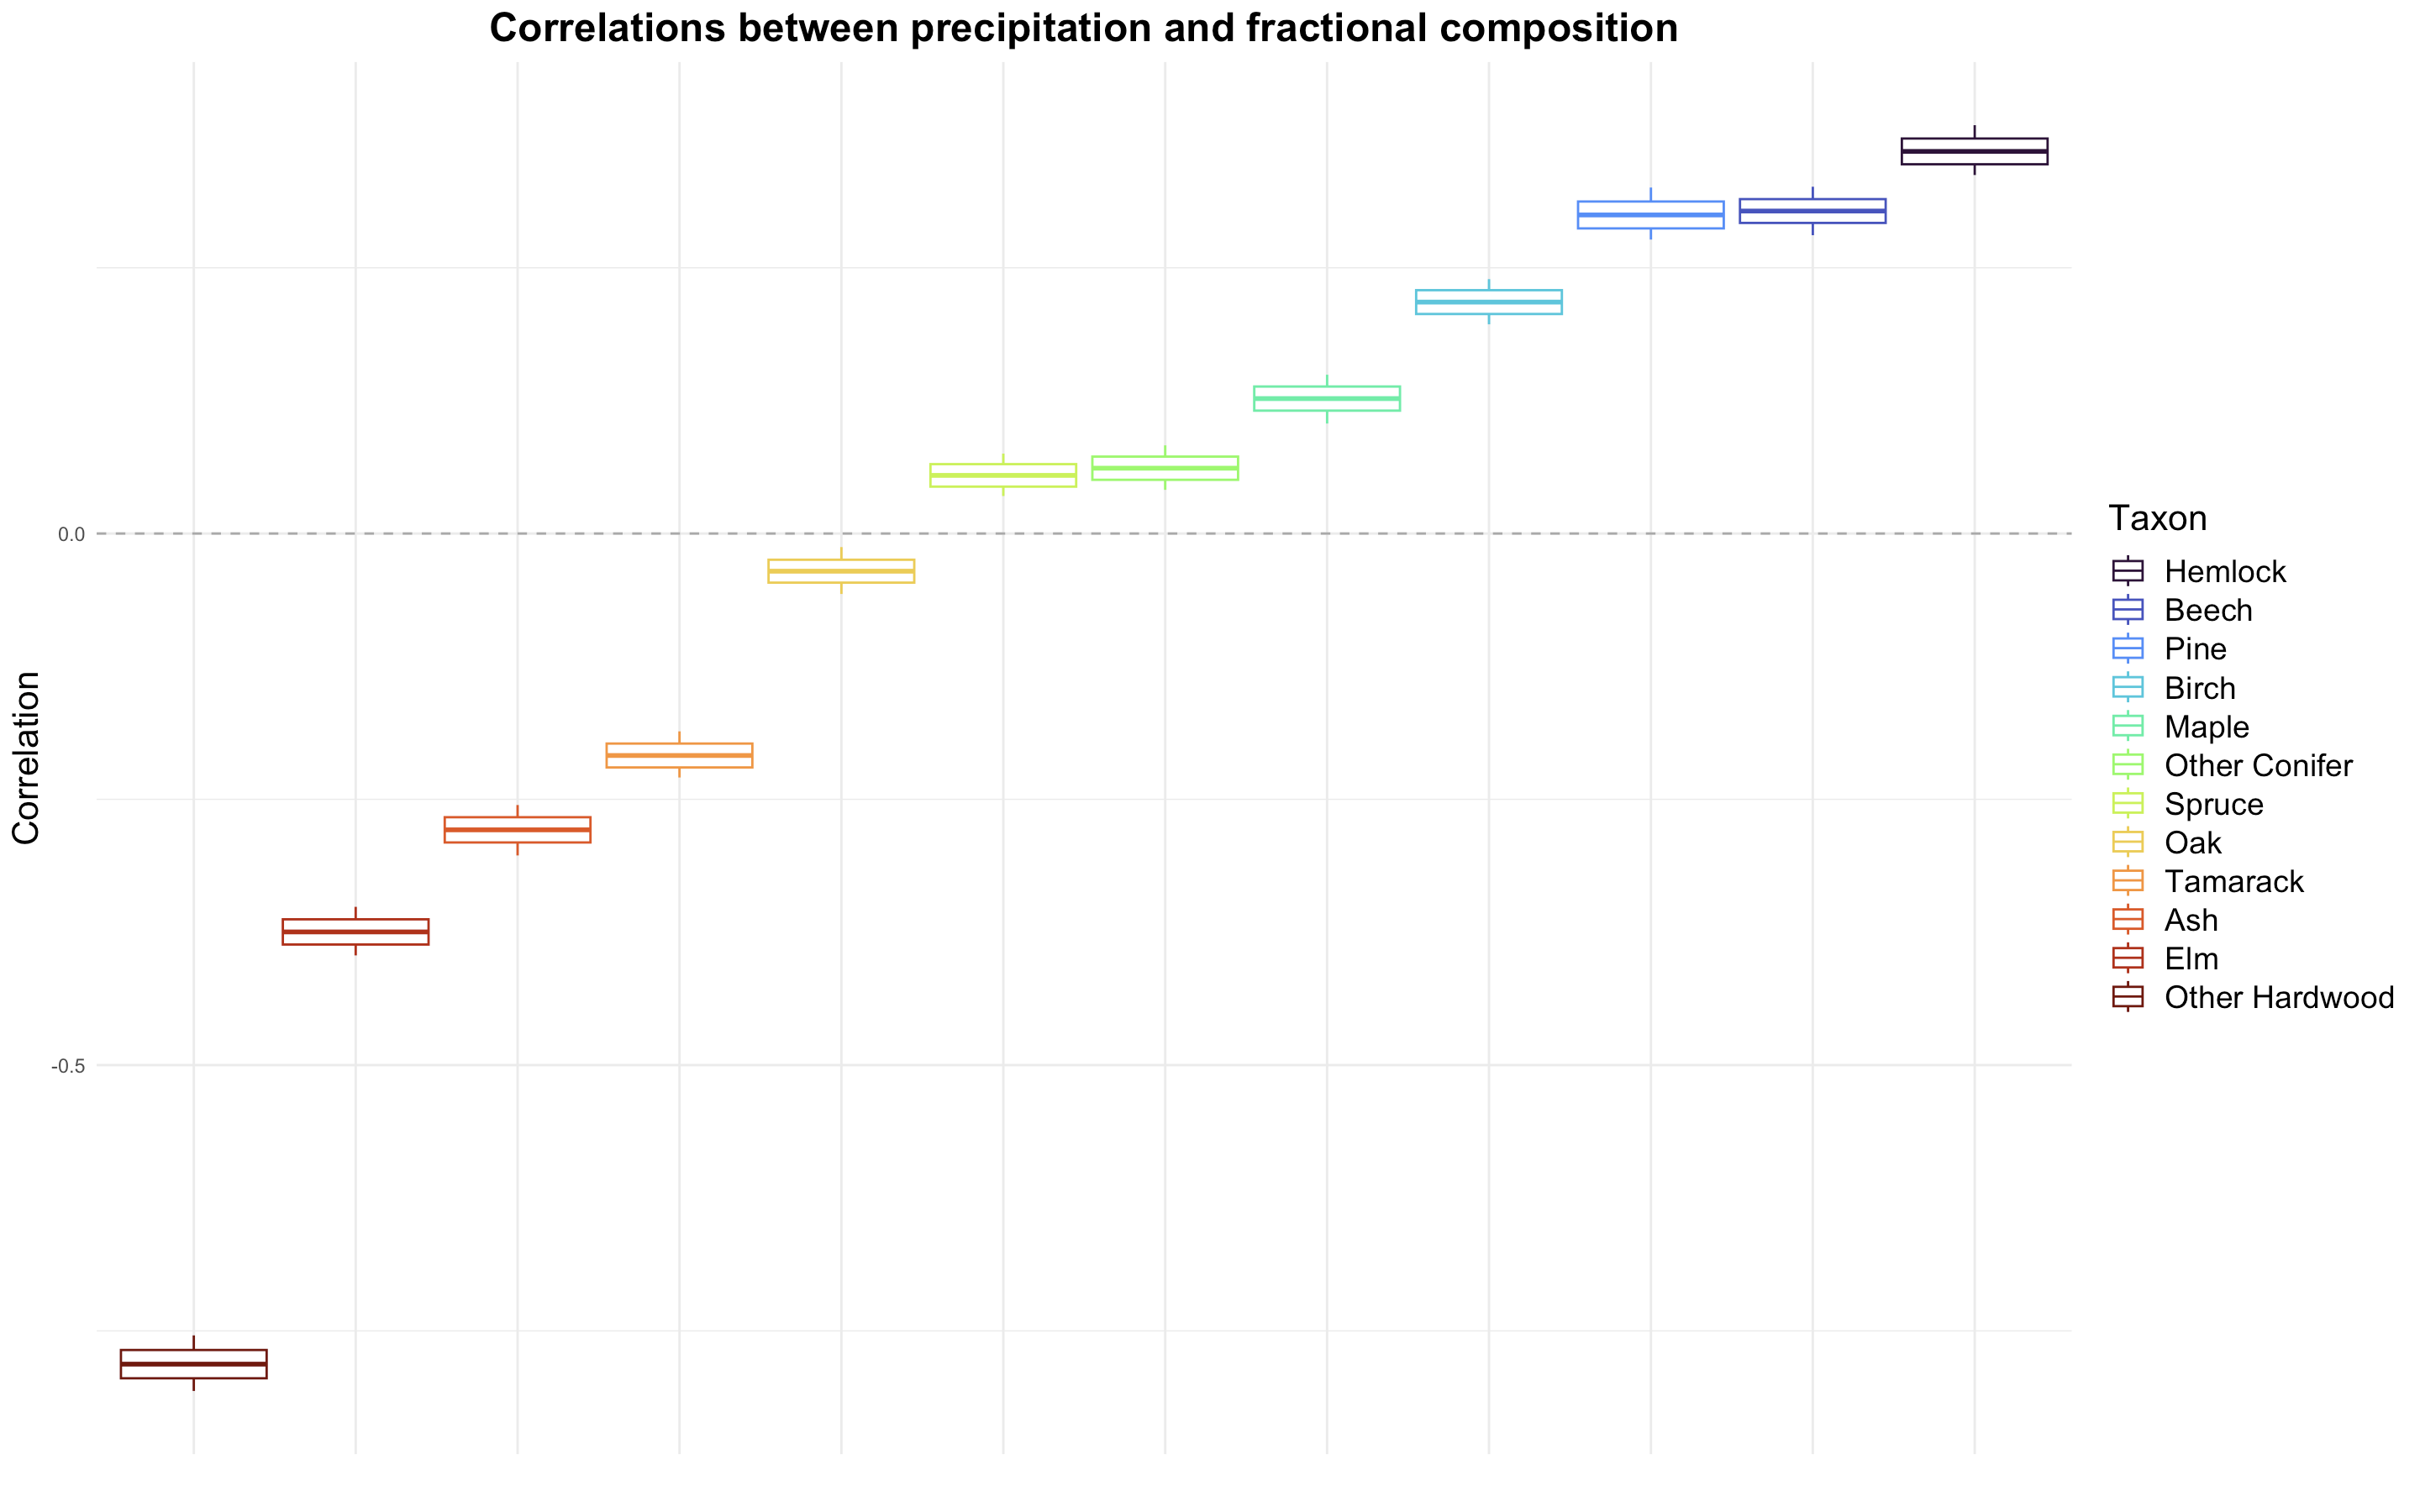

In [12]:
display.Image('/Users/Aly/Desktop/image9.png')

**Figure 9.** Correlations relating the climate driver precipitation to the fraction of the grid cell occupied by each taxon. Interpretation is the same as for Figure 7.

#### Correlations between taxa

After accounting for the relationship between climate and fractional composition, there remain residual correlations between taxa (Figure 10). This indicates that the fraciton of a given grid cell occupied by one taxon can be correlated with the fraction of the grid cell occupied by another species, beyond similarities in their temperature and precipitation niches. Specifically, oak is negatively correlated with many taxa, suggesting that oak tends to perpetuate its own habitat conditions by excluding other taxa, despite the climate being potentially suitable for more mesic taxa. Additionally, many forest tree taxa exhibit positive correlations, such as maple and hemlock.

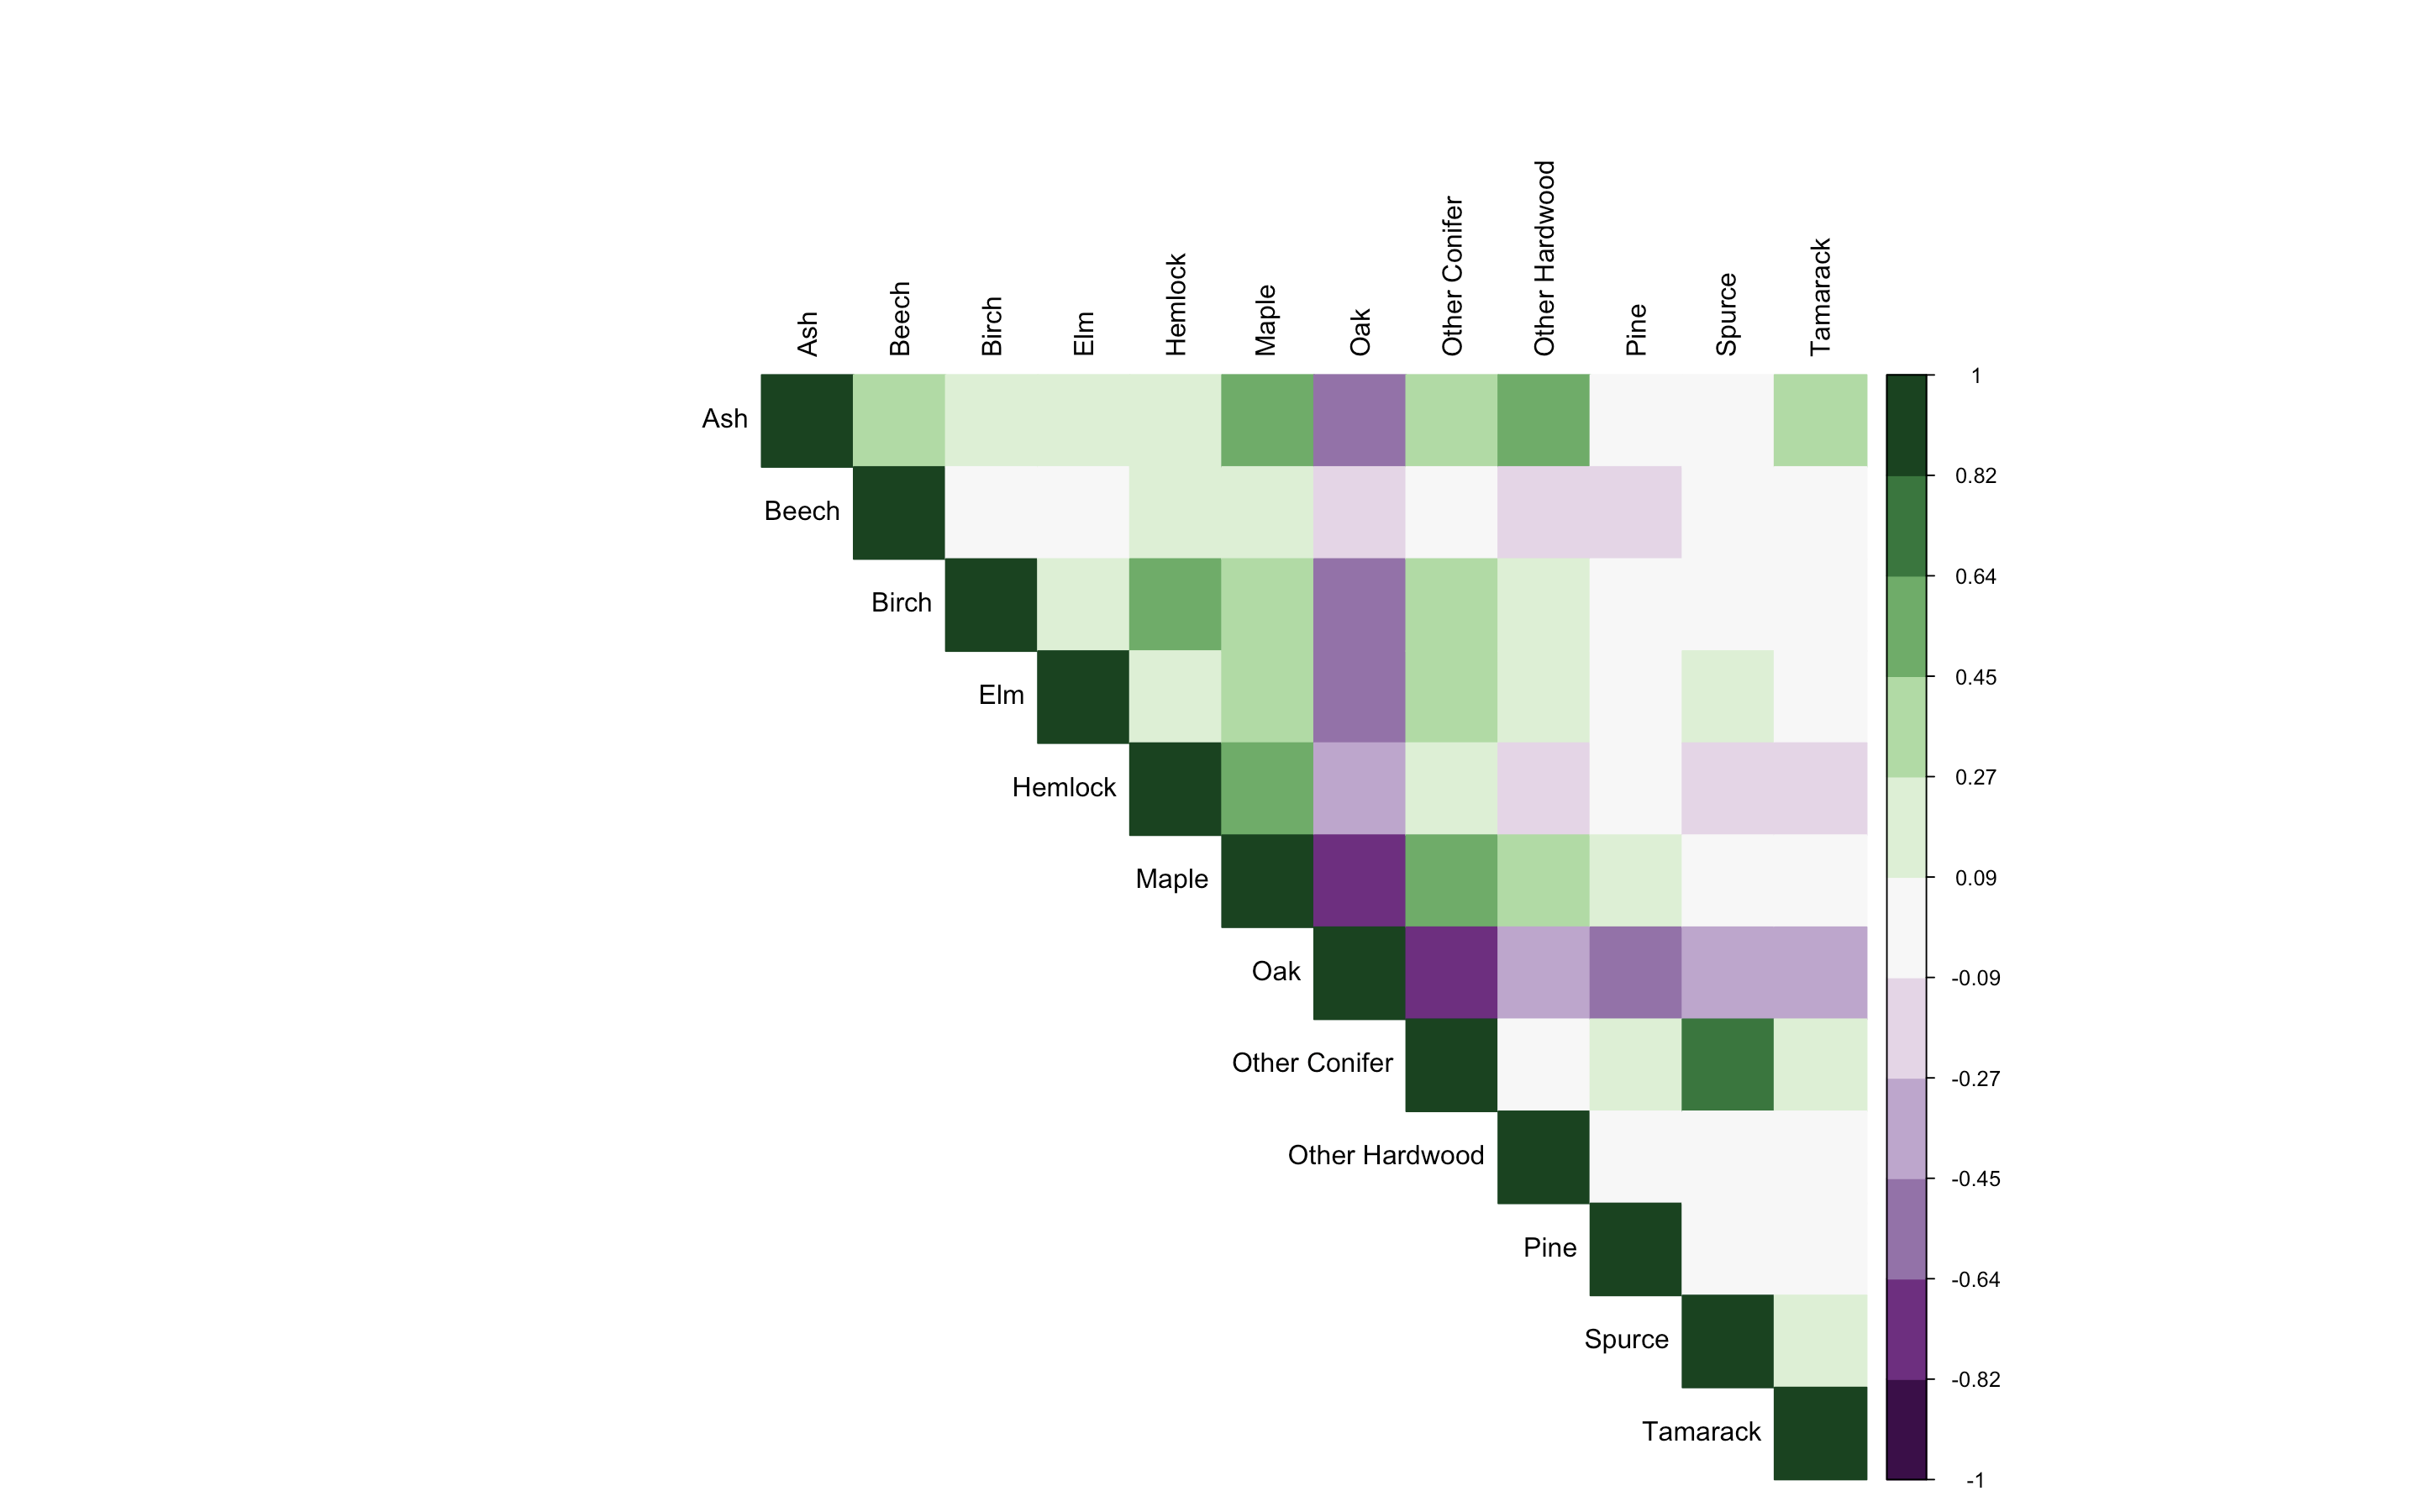

In [13]:
display.Image('/Users/Aly/Desktop/image10.png')

**Figure 10.** Correlations between taxa in terms of fractional composition, after accounting for the relationship between fractional composition and the climate drivers temperature and precipitation. The diagonal shows positive autocorrelation coefficients of 1. Above the diagonal, color represents the magnitude and direction of the correlation. White indicates near zero correlation. Purple shades indicate negative correlations. Green shades indicate positive correlations. Darker shades represent stronger correlations, while lighter shades represent weaker correlations.